In [ ]:
#import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE

#Drive connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#histogram function
def draw_histograms(dataframe, feature_columns):
    for col in feature_columns:
      plt.figure(figsize=(3, 2))
      plt.hist(dataframe[col], bins=50, color='#4682B4', edgecolor='#D3D3D3')
      plt.title(f'Histogram of {col}', color='#D3D3D3')
      plt.xlabel(col, color='#D3D3D3')
      plt.ylabel('Frequency', color='#D3D3D3')

      plt.tick_params(axis='both', colors='#D3D3D3')
      plt.gca().spines['bottom'].set_color('#D3D3D3')
      plt.gca().spines['left'].set_color('#D3D3D3')
      plt.gca().spines['top'].set_color('#D3D3D3')
      plt.gca().spines['right'].set_color('#D3D3D3')

      plt.grid(True, linestyle='--', alpha=0.8)
      plt.show()

#boxplot
def draw_boxplots(dataframe, numeric_cols):

  color='#1f4591'

  for col in numeric_cols:
    plt.figure(figsize=(3,3))
    sns.boxplot(data=dataframe[col], color=color, flierprops={'marker': 'o', 'markersize': 3})

    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(f"Boxplots of {col}", fontsize=10)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    plt.show()

#pairplot
def draw_pairplot(df, target_col):
  sns.pairplot(df, hue=target_col)
  plt.show()

#correlation heatmap
def draw_heatmap(df):
  plt.figure(figsize=(10, 8))
  sns.heatmap(df.corr(), annot=True, cmap='crest')
  plt.show()

##EDA

In [ ]:
#Data import form drive
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/project_dataset/Machine failure.csv')
#display the data
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
#dataset for binary clasification
df_maintenance = df.drop(['TWF','HDF','PWF', 'OSF', 'RNF'], axis=1)
df_maintenance.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0


In [ ]:
df_maintenance.shape

(10000, 9)

In [ ]:
df_maintenance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 703.3+ KB


In [ ]:
#feature descriptions
df_maintenance.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


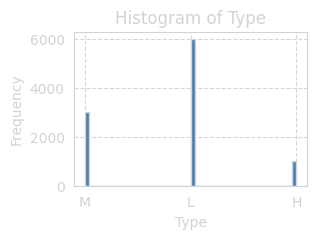

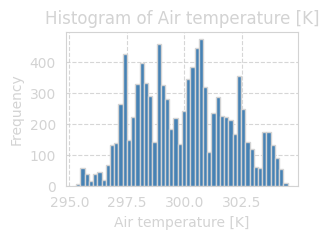

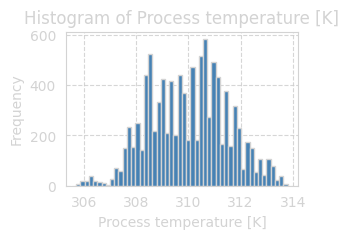

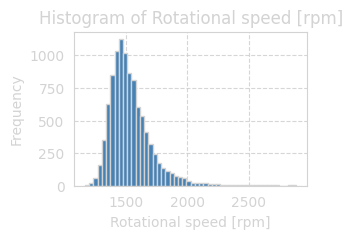

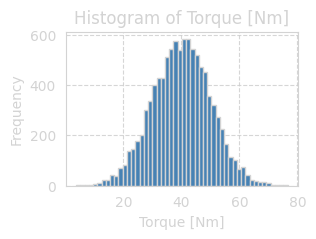

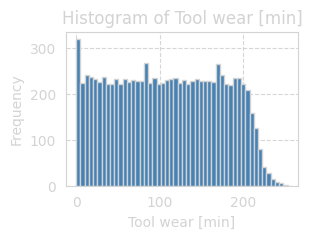

In [ ]:
#drop id cols
features_target_cols = df_maintenance.columns[2:]
#drop the target col
feature_cols = df_maintenance.columns[2:-1]
#numeric cols - numeric features w/target
num_cols = df_maintenance[features_target_cols].select_dtypes(include=['float64', 'int64']).columns
#target column
target_col = df_maintenance.columns[-1]

#numeric feature columns
num_features = df_maintenance[feature_cols].select_dtypes(include=['float64', 'int64']).columns
#categoric feature columns
cat_features = df_maintenance[feature_cols].select_dtypes(include=['object']).columns

draw_histograms(df_maintenance, feature_cols)

In [ ]:
df_maintenance[num_cols].skew()

,0
Air temperature [K],0.114274
Process temperature [K],0.015027
Rotational speed [rpm],1.993171
Torque [Nm],-0.009517
Tool wear [min],0.027292
Machine failure,5.151852


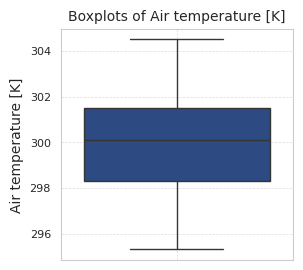

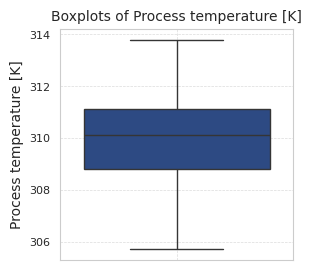

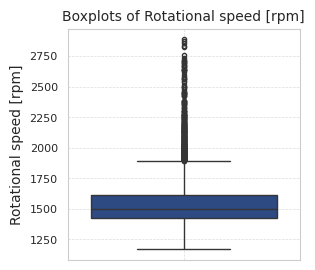

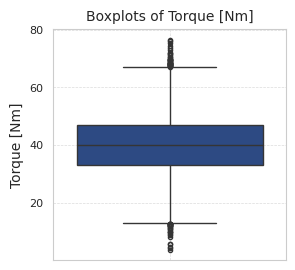

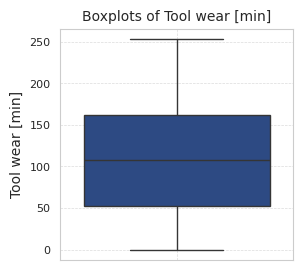

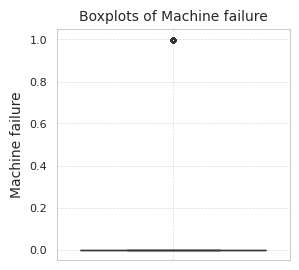

In [ ]:
draw_boxplots(df_maintenance, num_cols)

In [ ]:
for col in cat_features:
  print(df_maintenance[col].value_counts())

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


In [ ]:
freq_tables = {}
for col in cat_features:
    freq_tables[col] = df_maintenance[col].value_counts().reset_index()
    freq_tables[col].columns = [col, 'Frequency']  # Sütun isimlerini düzenle

all_freq_df = pd.concat(freq_tables.values(), axis=1)

# Eksik değerleri boş bırak
all_freq_df = all_freq_df.fillna('')

styled_freq_table = all_freq_df.style.set_properties(**{'text-align': 'left'}).set_caption('Frequency of Categorical Features').applymap(lambda x: 'background-color: darkblue' if x != '' else '')  # Boş olmayan hücrelere renk ekle

# Tabloyu göster
styled_freq_table

<ipython-input-62-3050853eb486>:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_freq_table = all_freq_df.style.set_properties(**{'text-align': 'left'}).set_caption('Frequency of Categorical Features').applymap(lambda x: 'background-color: darkblue' if x != '' else '')  # Boş olmayan hücrelere renk ekle


,Type,Frequency
0,L,6000
1,M,2997
2,H,1003


In [ ]:
df_maintenance[num_cols].corr()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448
Machine failure,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000


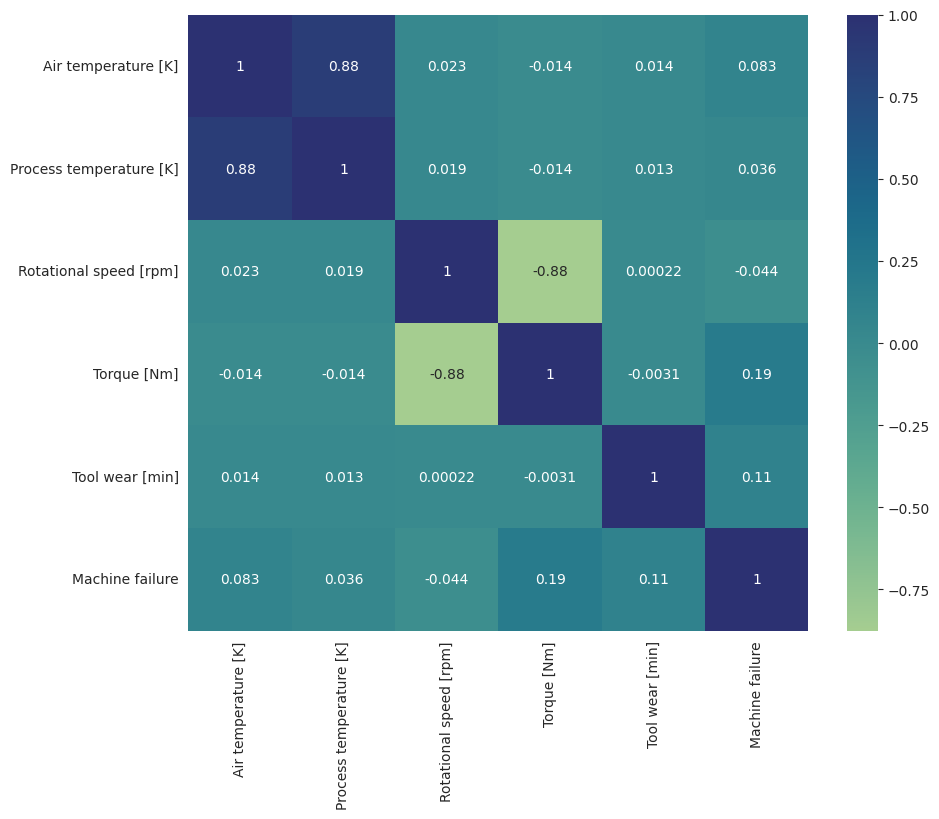

In [ ]:
draw_heatmap(df_maintenance[num_cols])

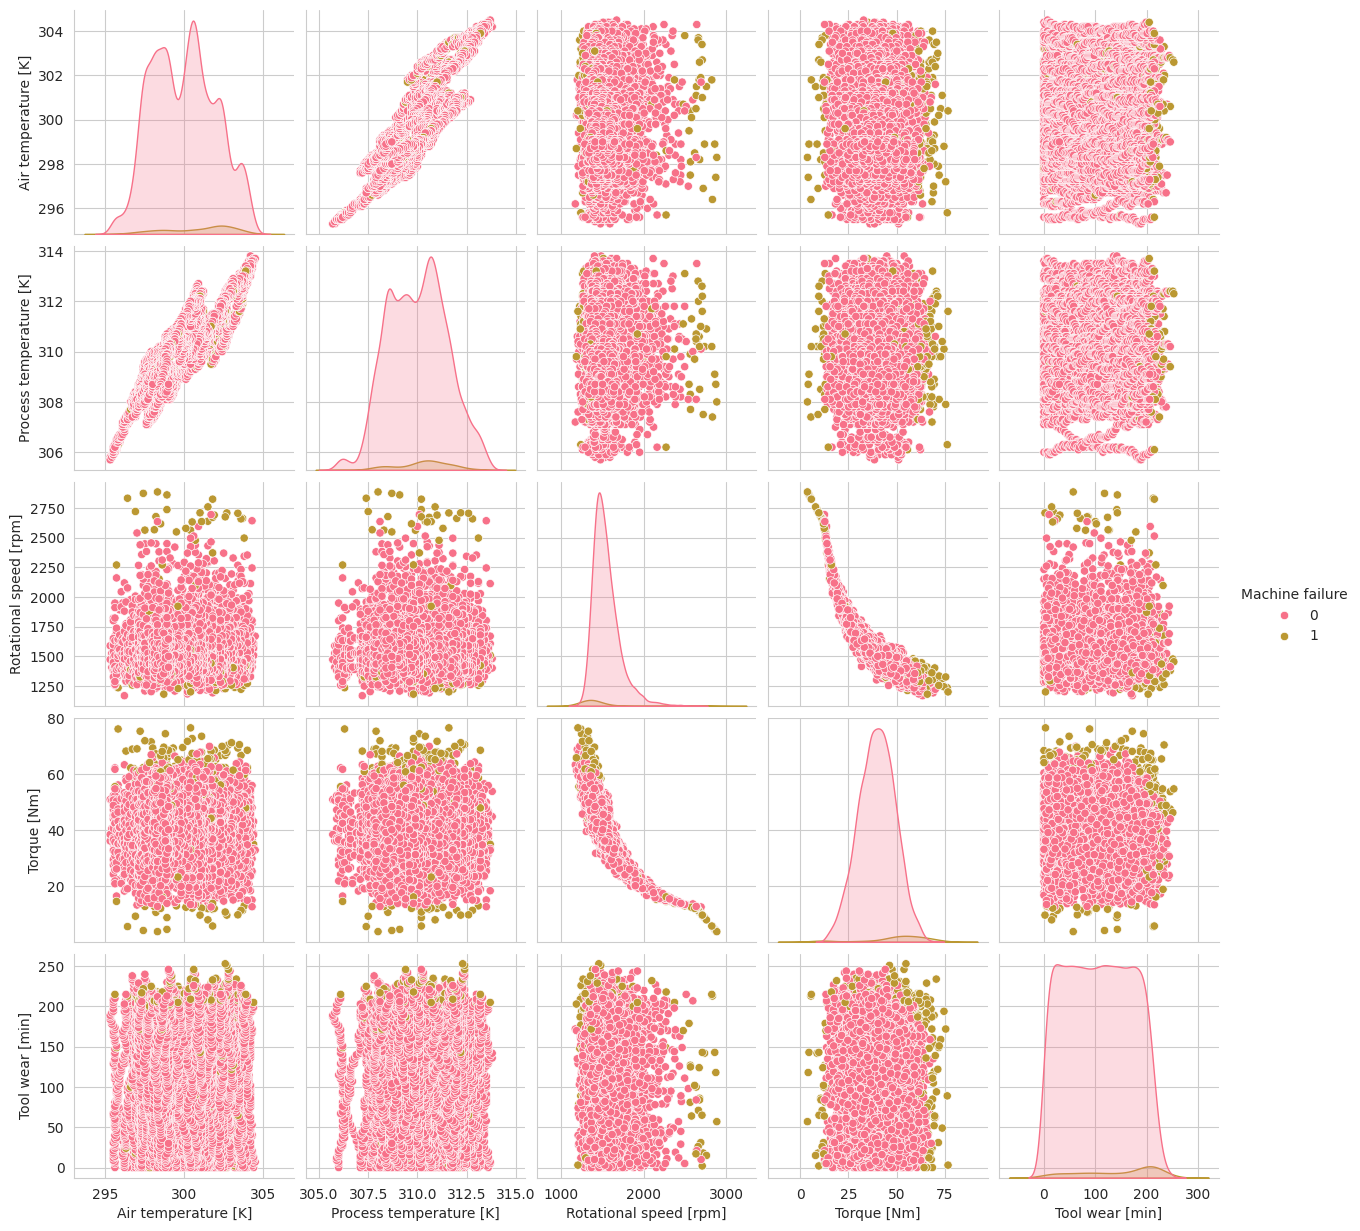

In [ ]:
draw_pairplot(df_maintenance[features_target_cols], target_col)

##Machine Learning

In [ ]:
feature_columns =df_maintenance.columns[2:-1]
num_cols = df_maintenance[feature_columns].select_dtypes(include=['float64', 'int64']).columns
target_col = df_maintenance.columns[-1]
df_maintenance['Type'].value_counts()

,count
Type,
L,6000
M,2997
H,1003


###Test/Train Split

In [ ]:
X = df_maintenance.drop(['UDI', 'Product ID' ,'Machine failure'], axis=1)
y =df_maintenance['Machine failure']

In [ ]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = encoder.fit_transform(X[['Type']])

encoded_col_names = encoder.get_feature_names_out(['Type'])
encoded_df = pd.DataFrame(encoded_cols, columns=encoded_col_names, index=X.index)
X = X.drop(columns=['Type']).join(encoded_df)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train['Rotational speed [rpm]'] = np.log1p(X_train['Rotational speed [rpm]'])
X_test['Rotational speed [rpm]'] = np.log1p(X_test['Rotational speed [rpm]'])

<ipython-input-70-872678776a90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Rotational speed [rpm]'] = np.log1p(X_train['Rotational speed [rpm]'])
<ipython-input-70-872678776a90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Rotational speed [rpm]'] = np.log1p(X_test['Rotational speed [rpm]'])


###DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(criterion= 'gini', random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
#predictions on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = cross_val_score(dt, X_train, y_train, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(dt, X_train, y_train, cv=cv, scoring='precision')
cv_recall = cross_val_score(dt, X_train, y_train, cv=cv, scoring='recall')
cv_f1 = cross_val_score(dt, X_train, y_train, cv=cv, scoring='f1')

print("**Cross-Validation Scores (Train Set)**")
print(f"Mean Accuracy: {np.mean(cv_accuracy):.4f}")
print(f"Mean Precision: {np.mean(cv_precision):.4f}")
print(f"Mean Recall: {np.mean(cv_recall):.4f}")
print(f"Mean F1 Score: {np.mean(cv_f1):.4f}")

**Cross-Validation Scores (Train Set)**
Mean Accuracy: 0.9804
Mean Precision: 0.7394
Mean Recall: 0.6532
Mean F1 Score: 0.6925


In [ ]:
y_pred = dt.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Performance on Test Data:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   index=['Actual Negative', 'Actual Positive'],
                   columns=['Predicted Negative', 'Predicted Positive']))

Performance on Test Data:
Precision: 0.6818
Recall: 0.6618
F1 Score: 0.6716
Accuracy: 0.9780
AUC: 0.8254

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.68      0.66      0.67        68

    accuracy                           0.98      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                1911                  21
Actual Positive                  23                  45


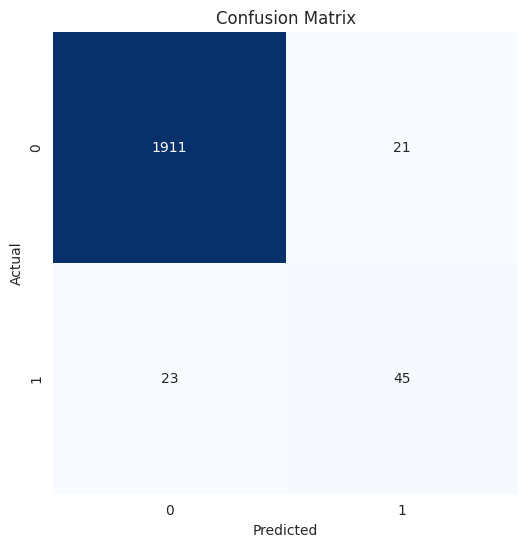

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(rf, X_train, y_train, cv=cv, scoring='precision')
cv_recall = cross_val_score(rf, X_train, y_train, cv=cv, scoring='recall')
cv_f1 = cross_val_score(rf, X_train, y_train, cv=cv, scoring='f1')

print("**Cross-Validation Scores (Train Set)**")
print(f"Mean Accuracy: {np.mean(cv_accuracy):.4f}")
print(f"Mean Precision: {np.mean(cv_precision):.4f}")
print(f"Mean Recall: {np.mean(cv_recall):.4f}")
print(f"Mean F1 Score: {np.mean(cv_f1):.4f}")

**Cross-Validation Scores (Train Set)**
Mean Accuracy: 0.9806
Mean Precision: 0.8687
Mean Recall: 0.5057
Mean F1 Score: 0.6370


In [ ]:
y_test_pred = rf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print("Performance on Test Data:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"AUC: {auc_test:.4f}")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                   index=['Actual Negative', 'Actual Positive'],
                   columns=['Predicted Negative', 'Predicted Positive']))

Performance on Test Data:
Accuracy: 0.9815
Precision: 0.8780
Recall: 0.5294
F1 Score: 0.6606
AUC: 0.7634
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.88      0.53      0.66        68

    accuracy                           0.98      2000
   macro avg       0.93      0.76      0.83      2000
weighted avg       0.98      0.98      0.98      2000

Confusion Matrix (Test):
                 Predicted Negative  Predicted Positive
Actual Negative                1927                   5
Actual Positive                  32                  36


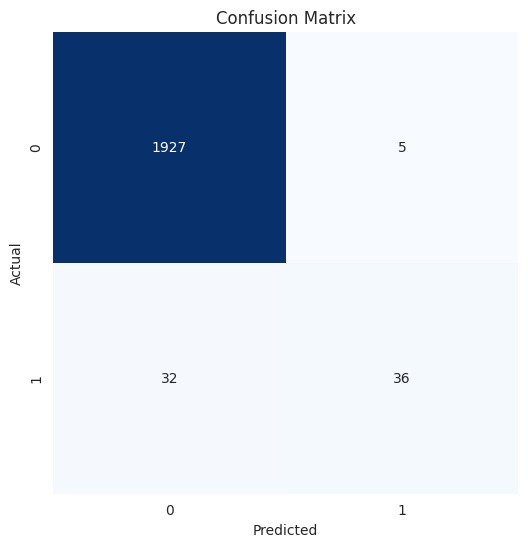

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###XGBoostClassifier

In [ ]:
X_train.columns = X_train.columns.str.replace('[', '').str.replace(']', '')
X_test.columns = X_test.columns.str.replace('[', '').str.replace(']', '')

In [ ]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
cv_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

print("**Cross-Validation Scores (Train Set)**")
print(f"Mean Accuracy: {np.mean(cv_accuracy):.4f}")
print(f"Mean Precision: {np.mean(cv_precision):.4f}")
print(f"Mean Recall: {np.mean(cv_recall):.4f}")
print(f"Mean F1 Score: {np.mean(cv_f1):.4f}")

**Cross-Validation Scores (Train Set)**
Mean Accuracy: 0.9839
Mean Precision: 0.8288
Mean Recall: 0.6644
Mean F1 Score: 0.7362


In [ ]:
y_test_pred_xgb = model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred_xgb)
precision_test = precision_score(y_test, y_test_pred_xgb)
recall_test = recall_score(y_test, y_test_pred_xgb)
f1_test = f1_score(y_test, y_test_pred_xgb)
auc_test = roc_auc_score(y_test, y_test_pred_xgb)

print("Performance on Test Data:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"AUC: {auc_test:.4f}")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred_xgb),
                   index=['Actual Negative', 'Actual Positive'],
                   columns=['Predicted Negative', 'Predicted Positive']))

Performance on Test Data:
Accuracy: 0.9875
Precision: 0.9057
Recall: 0.7059
F1 Score: 0.7934
AUC: 0.8516
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.91      0.71      0.79        68

    accuracy                           0.99      2000
   macro avg       0.95      0.85      0.89      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix (Test):
                 Predicted Negative  Predicted Positive
Actual Negative                1927                   5
Actual Positive                  20                  48


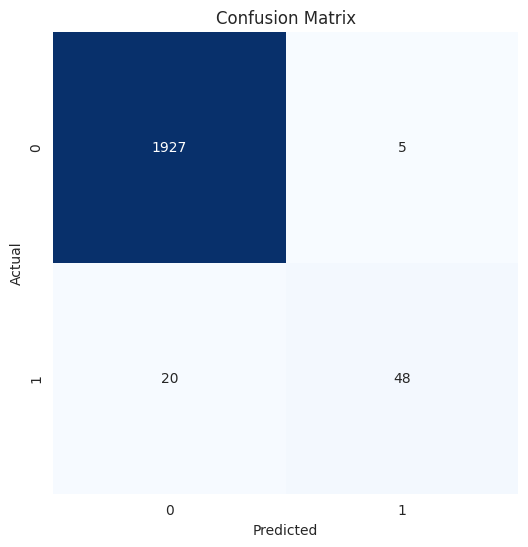

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_xgb)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

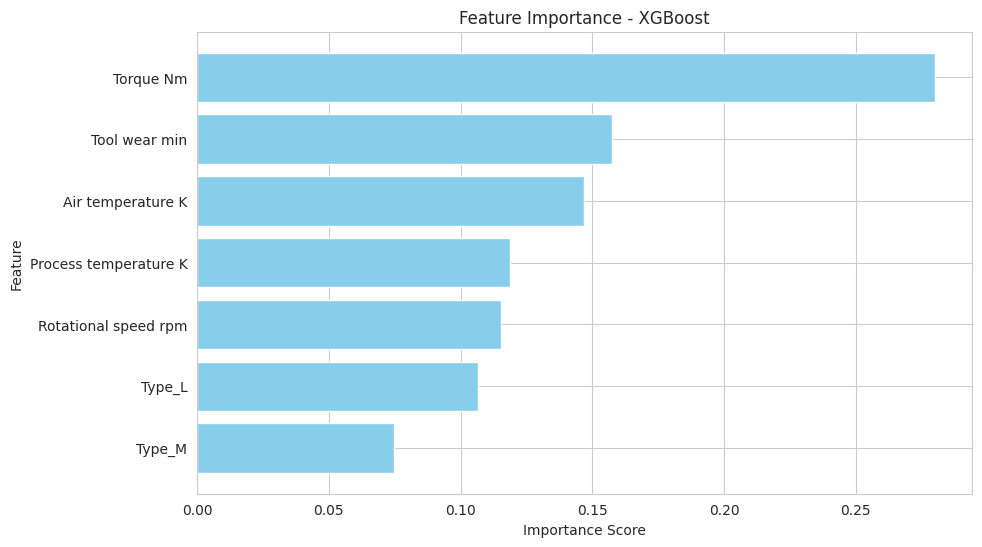

In [ ]:
importance = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

###XGBoostClassifier FineTuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search_xgb.fit(X_train, y_train)

print("Best Parameters:", grid_search_xgb.best_params_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


Precision: 0.8868
Recall: 0.6912
F1 Score: 0.7769
Accuracy (Best Model): 0.9865
AUC (Best Model): 0.9700

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.89      0.69      0.78        68

    accuracy                           0.99      2000
   macro avg       0.94      0.84      0.88      2000
weighted avg       0.99      0.99      0.99      2000



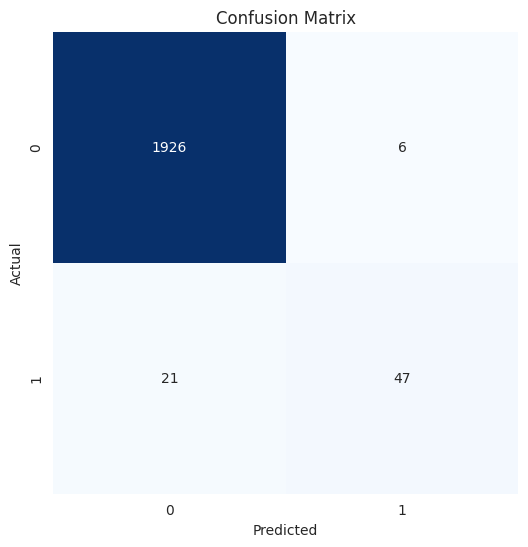

In [ ]:
best_model = grid_search_xgb.best_estimator_

y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
auc_best_model = roc_auc_score(y_test, y_prob_best)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Accuracy (Best Model): {accuracy_score(y_test, y_pred_best):.4f}')
print(f'AUC (Best Model): {auc_best_model:.4f}')

print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()